In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb 
sb.set_style("whitegrid", {'axes.grid' : False})
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## Exploratory Analysis and Data Munging

In [3]:
lifetime = pd.read_csv('Courier_lifetime_data.csv')
weekly = pd.read_csv('Courier_weekly_data.csv')

In [4]:
len(set(list(lifetime.courier)))

7524

In [5]:
len(set(list(weekly.courier)))

759

* only 1/10 aprox. of the couriers have weekly data

### Explore distributions of weekly data

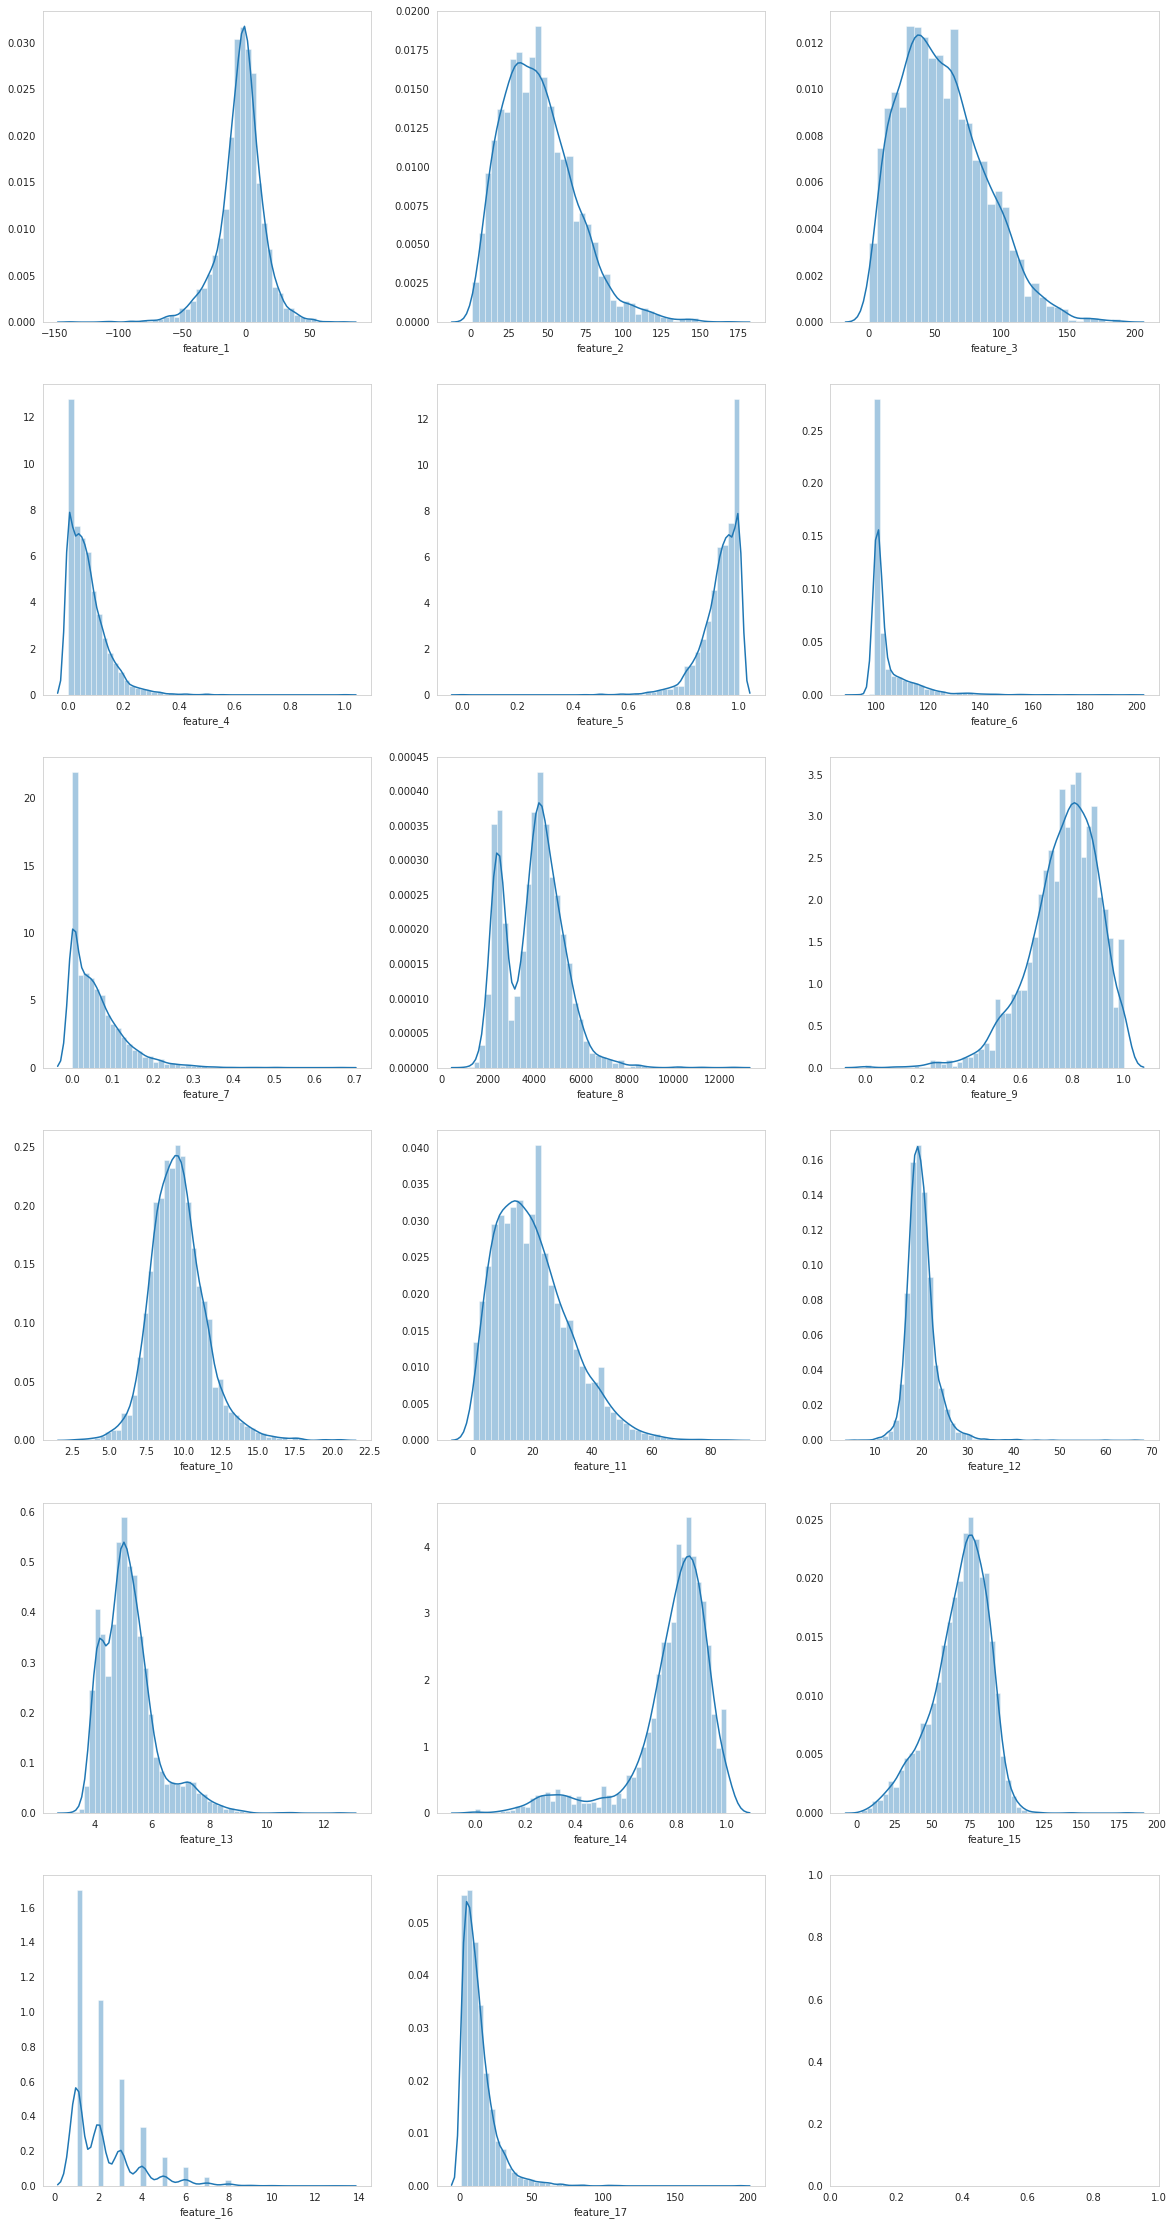

In [28]:
fig, axes = plt.subplots(6, 3, figsize=(20,40))
ax = axes.flatten() #ravel()

for i in range(len(weekly.columns[2:])):
    sb.distplot(weekly[weekly.columns[2:][i]], ax=ax[i])


In [7]:
# keep only feature_2 values within +3 to -3 standard deviations 
outliers_ix = lifetime.index[np.abs(lifetime.feature_2-lifetime.feature_2.mean()) >= (3*lifetime.feature_2.std())]
lifetime.loc[outliers_ix, 'feature_2'] = np.NaN

### Explore distributions grouped by categories in lifetime feature 1 (a,b,c,d)

In [8]:
#1st find couriers that do have weekly data to inspect the distributions
merge = pd.merge(lifetime, weekly, on='courier', how='right') #.to_csv('merge.csv')

#Then get the complete dataset. Lots of couriers will have lifetime data but no weekly data:
merge_all = pd.merge(lifetime, weekly, on='courier', how='left') #.to_csv('merge.csv')

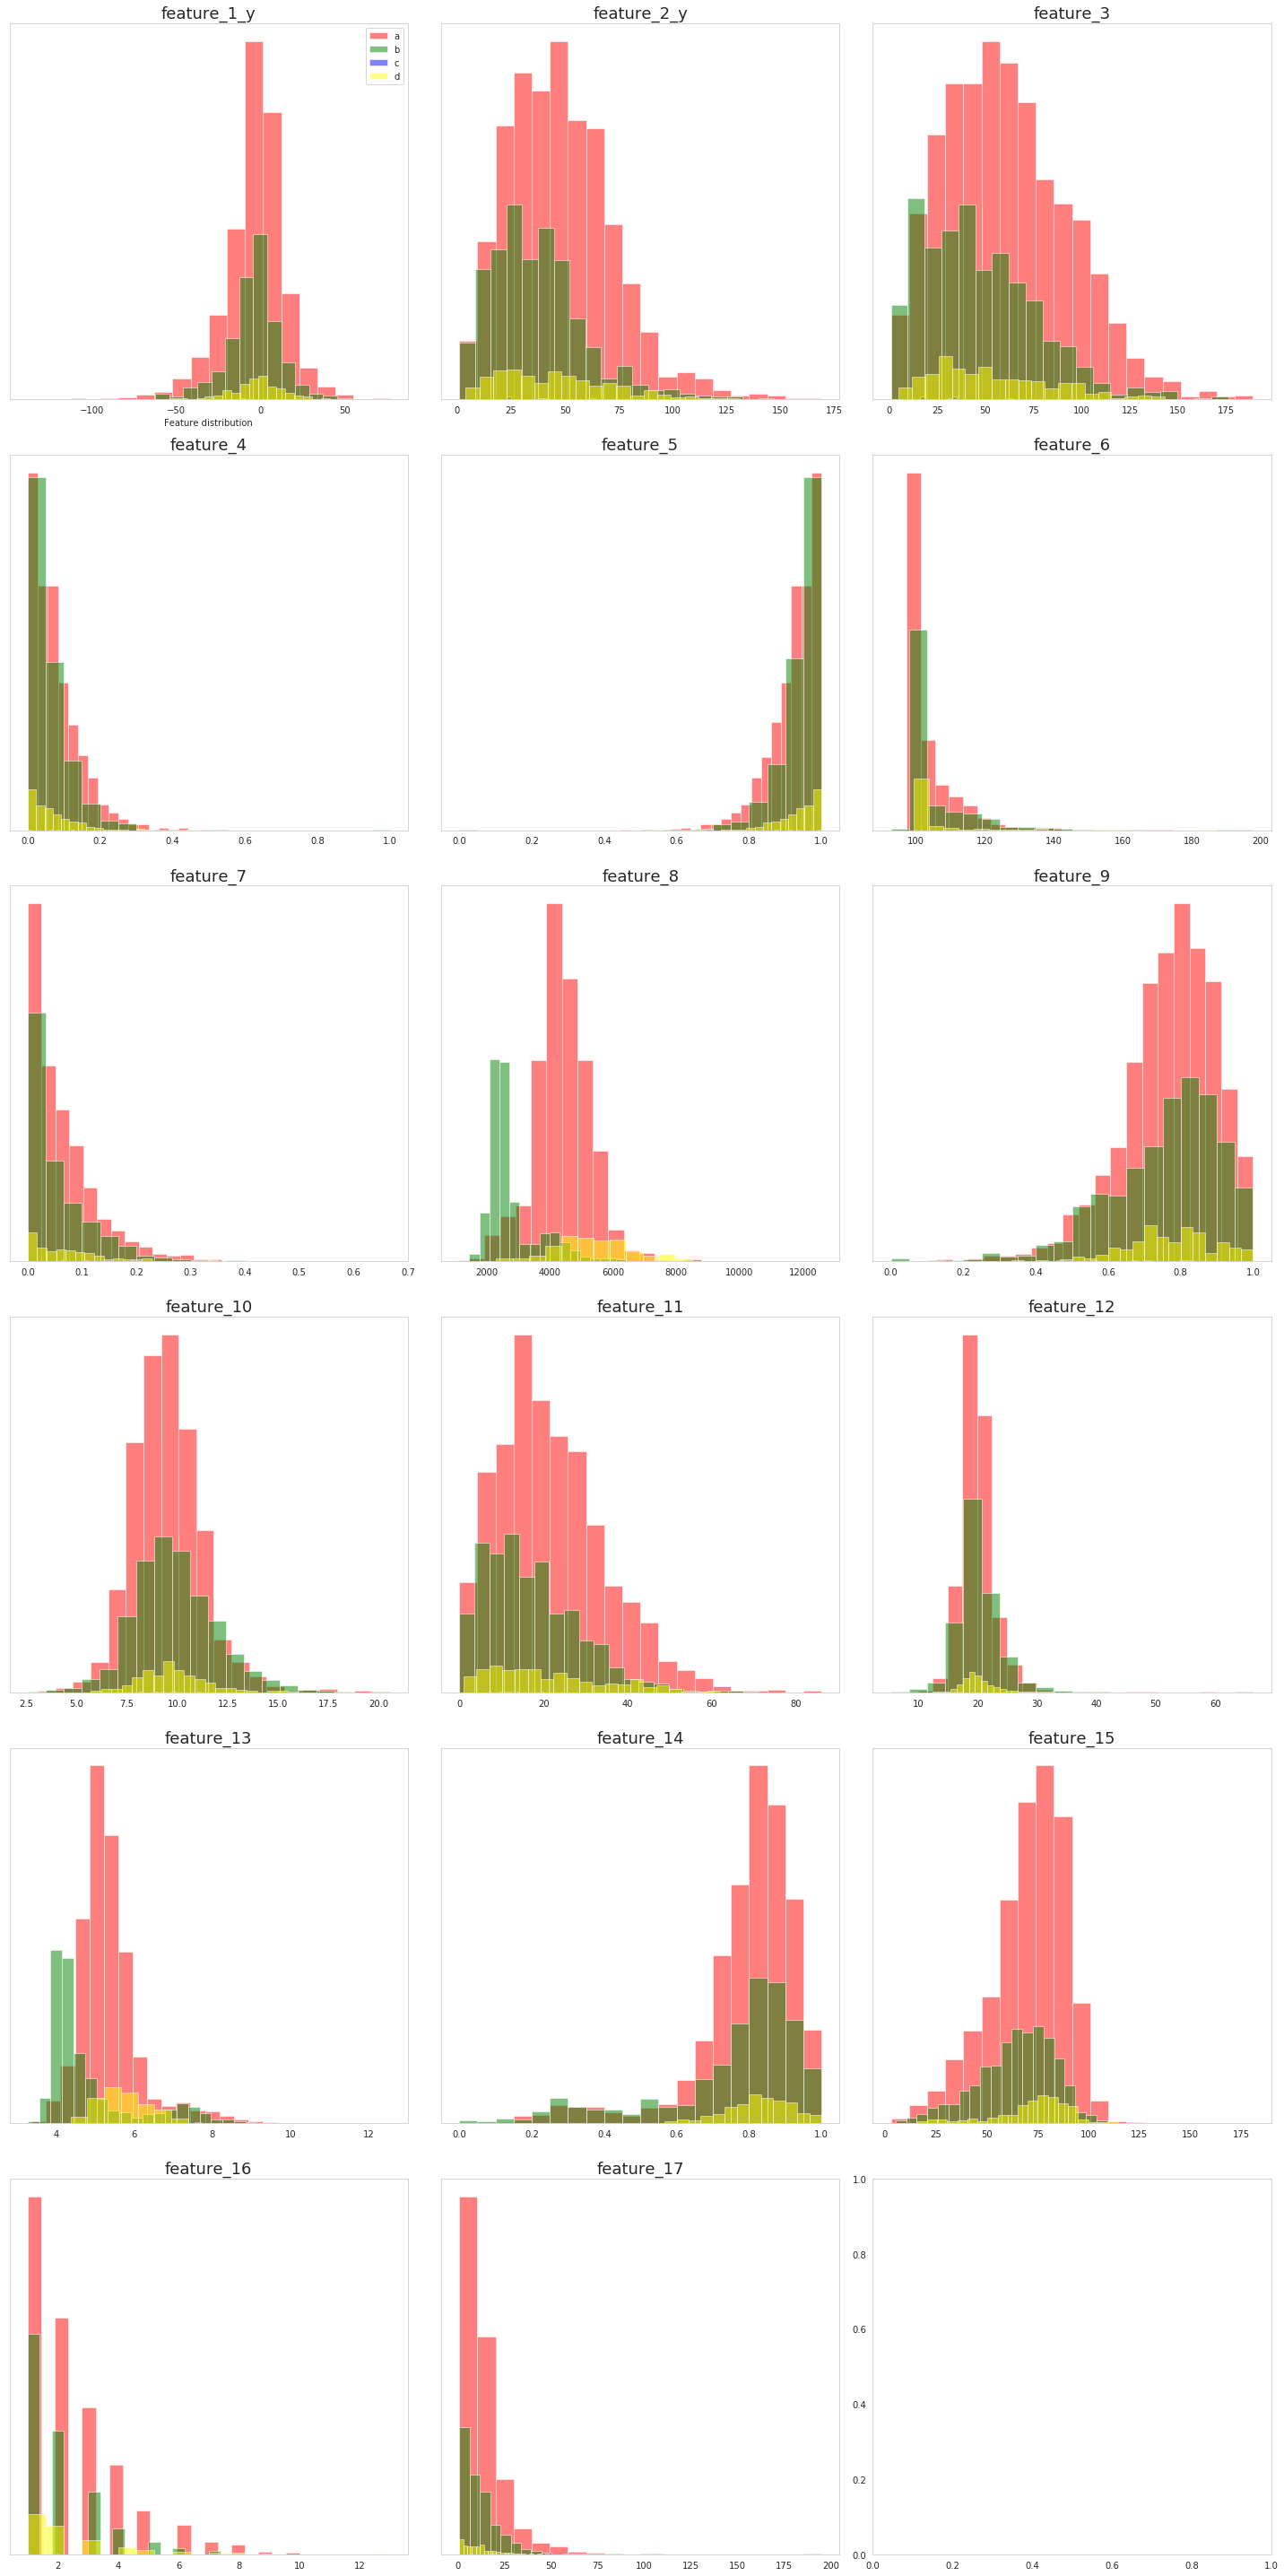

In [29]:

a = merge.loc[merge.feature_1_x=='a']
b = merge.loc[merge.feature_1_x=='b']
c = merge.loc[merge.feature_1_x=='c']
d = merge.loc[merge.feature_1_x=='d']

weekly_features = ['feature_1_y','feature_2_y', 'feature_3', 
                   'feature_4', 'feature_5', 'feature_6',
                   'feature_7', 'feature_8', 'feature_9',
                   'feature_10', 'feature_11','feature_12',
                   'feature_13', 'feature_14', 'feature_15',
                   'feature_16','feature_17']

fig, axes = plt.subplots(6, 3, figsize=(20,40))

ax = axes.flatten() #ravel()

for i in range(len(weekly_features)):
    ax[i].hist(a.loc[:,weekly_features[i]], bins=20, color='red', alpha=.5)
    ax[i].hist(b.loc[:,weekly_features[i]], bins=20, color='green', alpha=.5)
    ax[i].hist(c.loc[:,weekly_features[i]], bins=20, color='blue', alpha=.5)
    ax[i].hist(d.loc[:,weekly_features[i]], bins=20, color='yellow', alpha=.5)
    ax[i].set_title(weekly_features[i], fontsize=18)
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature distribution")
ax[0].legend(["a", "b", "c", "d"], loc="best")
fig.tight_layout()


plt.show()

* Some of the features are clearly dependent on the category: a, b, c, d. Like feature 8 and feature 15
* Category a has the most weekly data. In other words, most of the couriers that have weekly data belong to a
* Category c has almost no weekly data

### Impute missing values with combinations of lifetime's feature_1 and feature_2
For example, of 103 couriers with feature1 == 'a' and feature2 == 31.0  
43 of them have weekly data. Impute the remaining 60 ones with the median of the 43

In [31]:
list_f1 = list(set(merge_all.feature_1_x))
list_f2 = list(set(merge_all[merge_all.feature_2_x.notnull()].feature_2_x))

frames = []
for f1 in list_f1:
    for f2 in list_f2:
        df = merge_all.loc[merge_all.feature_1_x==f1][merge_all.feature_2_x==f2]
        if len(df.dropna())>0: #some feature 1, feature 2 combinations don't have any weekly data at all
            df = df.fillna(df[weekly_features].dropna().median())
            frames.append(df)
        else:
            df = df.fillna(merge_all.loc[merge_all.feature_1_x==f1].dropna().median())
            frames.append(df)
    #And then for the 1227 couriers that have feature_1 but no feature_2 just impute the median of the whole group a, b, c, d
    for f1 in list_f1:
        df = merge_all[merge_all.feature_2_x.isnull()][merge_all.feature_1_x==f1]
        df = df.fillna(df[weekly_features].dropna().median())
        frames.append(df)
data = pd.concat(frames)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [11]:
#But in the imputed data, feature_2_x is still missing
missing_f2 = len(data[data['feature_2_x'].isnull()])
print("rows missing feature_2_x: %s"%missing_f2)

rows missing feature_2_x: 1227


In [12]:
#With the imputed data I can now knn-predict those feature_2_x:
X = np.matrix(data[data['feature_2_x'].notnull()][weekly_features])
y = np.matrix(data['feature_2_x'].dropna()).T

#k = 5 by default
regr = KNeighborsRegressor().fit(X, y)
feature_2_x_ = regr.predict(np.matrix(data[weekly_features]))#[:, 'feature_2_x']
data['feature_2_x_'] = feature_2_x_ #[int(i) for i in feature_2_x_]
#Replace the missing values in feature_2_x with the knn-predicted feature_2_x_ values
missing_f2_ix = data.index[data.feature_2_x.isnull()]
predicted_f2  = data[data.feature_2_x.isnull()].feature_2_x_
data.loc[missing_f2_ix, 'feature_2_x'] = predicted_f2
data.sample(10)

,courier,feature_1_x,feature_2_x,week,feature_1_y,feature_2_y,feature_3,feature_4,feature_5,feature_6,...,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_2_x_
6068,479270,a,38.0,5.0,9.0,25.0,40.0,0.1500,0.8500,101.5000,...,0.67500,8.478333,11.0,18.774250,4.685250,0.70000,93.303333,2.0,5.0,32.6
4502,406948,a,37.0,7.0,26.0,47.0,85.0,0.2118,0.7882,101.1765,...,0.64710,7.459407,19.0,20.938235,4.538353,0.67060,83.684397,1.0,13.0,44.2
1509,161658,a,21.0,NaN,-5.0,53.0,74.0,0.0387,0.9613,103.5385,...,0.79050,8.766991,22.0,18.996833,4.692308,0.84460,65.357966,3.0,21.0,21.0
8854,789168,d,25.0,NaN,-6.5,17.5,28.5,0.0645,0.9355,101.4516,...,0.73945,9.453535,11.5,23.976030,5.860850,0.84865,94.070769,1.0,5.5,25.0
8855,789189,b,18.0,NaN,-14.0,27.0,33.0,0.0294,0.9706,100.0000,...,0.84850,10.196289,11.0,21.888889,4.400000,0.87880,65.511905,1.0,7.0,18.0
1634,170520,a,21.0,NaN,-5.0,53.0,74.0,0.0387,0.9613,103.5385,...,0.79050,8.766991,22.0,18.996833,4.692308,0.84460,65.357966,3.0,21.0,21.0
3697,351276,b,33.0,3.0,17.0,44.0,75.0,0.0667,0.9333,100.0000,...,0.62670,9.880668,31.0,18.331600,4.185467,0.80000,79.421717,1.0,7.0,28.8
2292,243351,c,34.4,NaN,-10.0,39.0,34.0,0.1250,0.8750,101.2500,...,0.70590,9.331859,12.0,17.281250,6.312286,0.79410,53.031401,1.0,19.0,34.4
5636,466348,a,27.0,6.0,-18.0,73.0,95.0,0.0526,0.9474,100.6316,...,0.74740,8.471926,29.0,20.503053,5.840842,0.86320,67.828006,5.0,15.0,33.0
10547,931282,b,21.0,NaN,-5.5,21.0,27.0,0.0077,0.9923,100.0000,...,0.85645,9.989977,10.0,18.835366,4.245913,0.86935,67.244751,2.0,6.0,21.0


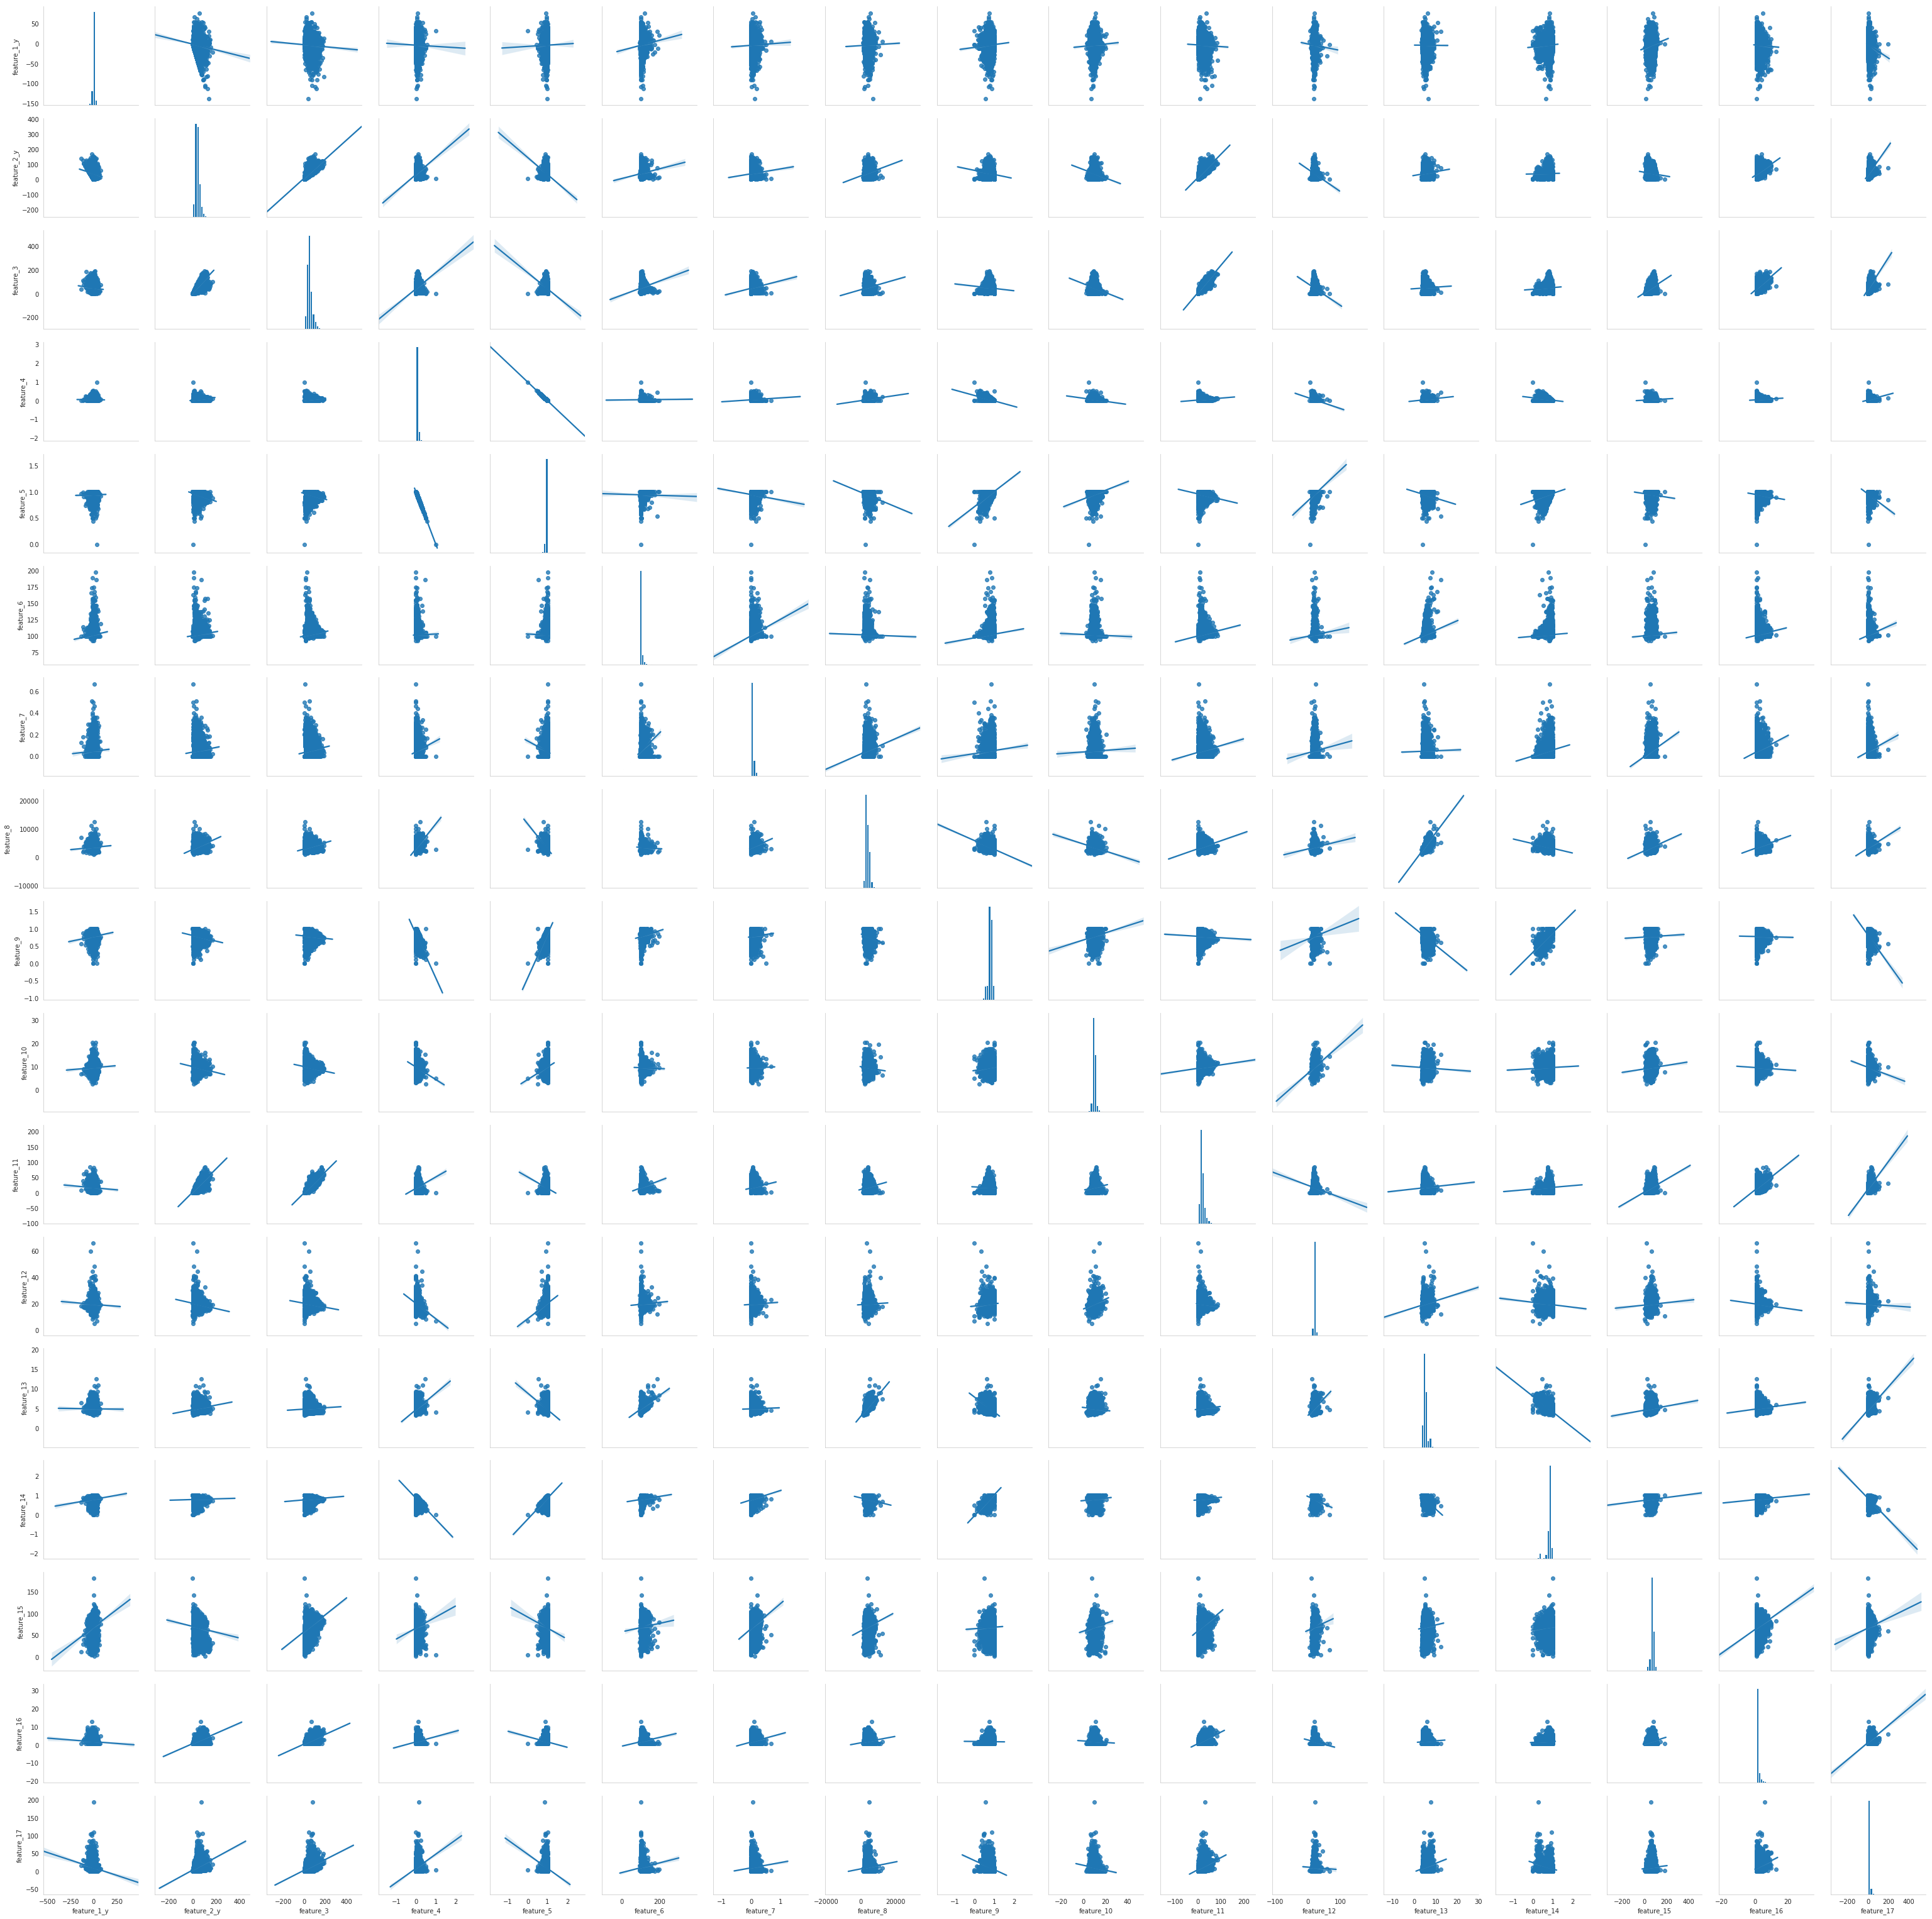

In [28]:
sb.pairplot(data[weekly_features], kind="reg")
plt.show()

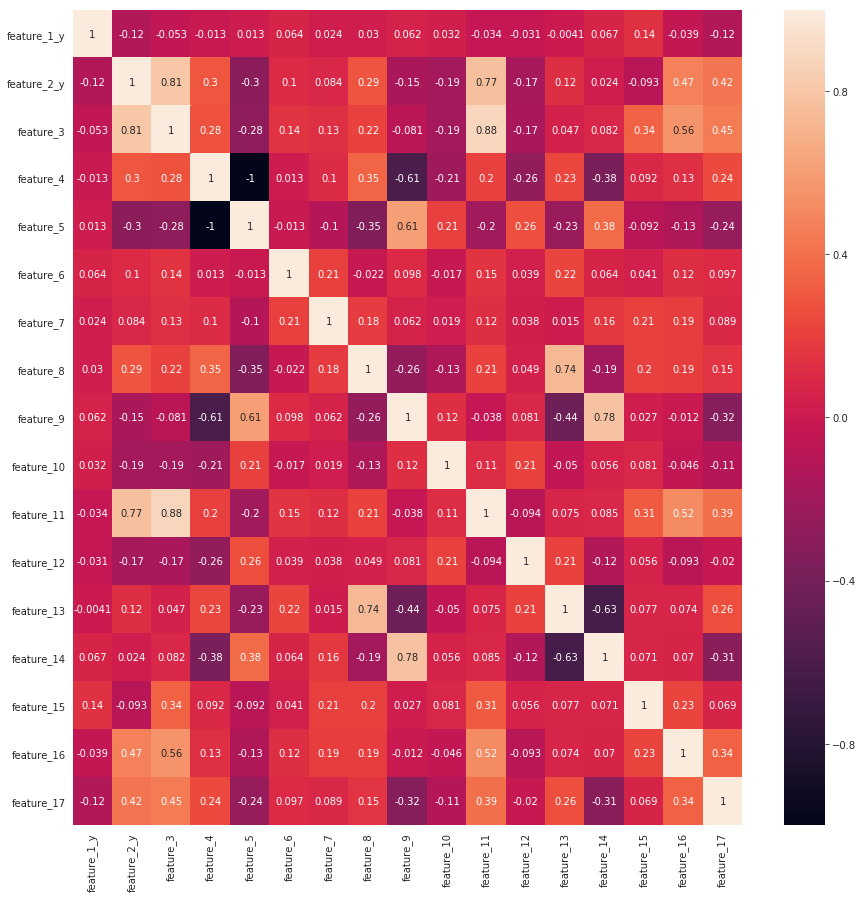

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(data[weekly_features].corr(), annot=True)

* feature 2 and feature 3:  0.81
* feature 2 and feature 11: 0.77
* feature 3 and feature 11: 0.88
* feature 4 and feature 5:  -1
* feature 8 and feature 13: 0.74
* feature 9 and feature 14: 0.78

Label data. If a specific courier’s week 9, 10 and 11 data is not provided, we label this
courier as “1” otherwise “0”. After labeling, remove week 8(Yes including 8!), 9, 10 and 11 data to
avoid bias in your next task

In [18]:
data['label'] = ''*len(data)

last_weeks = [9,10,11]

grouped = data.groupby('courier')

couriers1 = list(set(grouped.filter(lambda x: x.week.max() < 9).courier))
couriers0 = list(set(grouped.filter(lambda x: x.week.max() >= 9).courier))


data.loc[data[data.courier.isin(couriers1)].index, 'label'] = 1
data.loc[data[data.courier.isin(couriers0)].index, 'label'] = 0

#there are a lot of couriers that don't have week data (bc they didn't have weekly data at all). Label those 1
data.loc[data[data.label==''].index, 'label'] = 1 




### create a logistic regression model to classify the labels

### Finally, tune hyper-parameters of your model by randomized search, grid search or any other search method and explain your reasoning for this choice.

In [20]:



x_train, x_test, y_train, y_test = train_test_split(data[weekly_features], data.label, test_size=0.25, random_state=0)

#1st try default parameters
logisticRegr = \
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

logisticRegr.fit(x_train, y_train)

predictions = logisticRegr.predict(x_test)


In [21]:
print(confusion_matrix(y_test,predictions))
#TP FP
#TN FN

[[ 290  414]
 [ 112 1905]]


In [23]:
print(classification_report(y_test, predictions))
#precison = TP / (TP+TN)
#recall   = TP / (TP+FP)
#f1-score = 2 (precision recall) / (precision + recall)

             precision    recall  f1-score   support

          0       0.72      0.41      0.52       704
          1       0.82      0.94      0.88      2017

avg / total       0.80      0.81      0.79      2721



In [ ]:
print(accuracy_score(y_test,predictions))